<a href="https://colab.research.google.com/github/pseudope/Parrot_5th_Level1/blob/main/MNIST_Week2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
!pip install einops
#!pip install tensorflow --user

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization

from einops import rearrange
from sklearn.model_selection import train_test_split

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


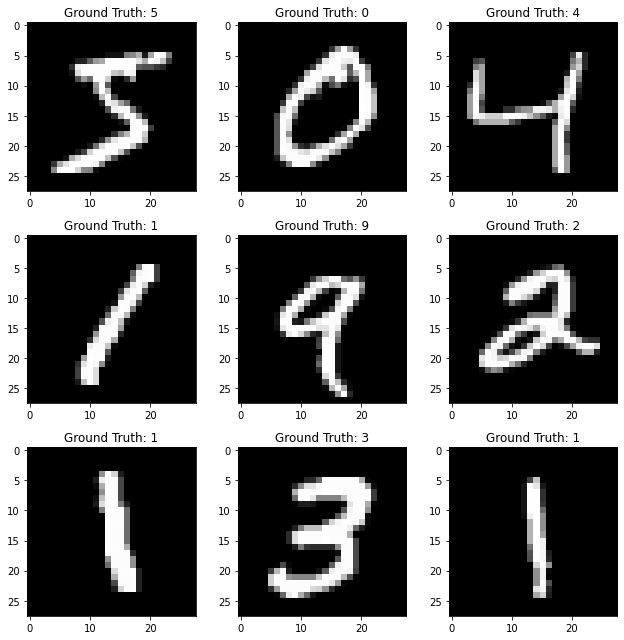

In [3]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

In [4]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size)         # 타겟을 정수로 변환

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


Changes Made:
*   1st conv layer kernel_initializer='he_normal'

*   patience increased to 7











In [7]:
inputs = Input(shape=(28, 28, 1))

X = Conv2D(filters=128, kernel_size=(3, 3), padding="Same", kernel_initializer='he_normal')(inputs)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=128, kernel_size=(3, 3), padding="Same", activation="relu")(X)
#X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=(3, 3), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu")(X)
#X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Flatten()(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(128, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.4)(X)
X = Dense(64, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(10, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584

In [12]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = [
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
]

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, callbacks = callback, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
188/188 [==============================] - 22s 111ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.2438 - val_accuracy: 0.9376
Epoch 2/20
188/188 [==============================] - 20s 108ms/step - loss: 0.0297 - accuracy: 0.9914 - val_loss: 0.0441 - val_accuracy: 0.9882
Epoch 3/20
188/188 [==============================] - 20s 108ms/step - loss: 0.0263 - accuracy: 0.9921 - val_loss: 0.0402 - val_accuracy: 0.9902
Epoch 4/20
188/188 [==============================] - 20s 108ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0317 - val_accuracy: 0.9917
Epoch 5/20
188/188 [==============================] - 20s 108ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0363 - val_accuracy: 0.9903
Epoch 6/20
188/188 [==============================] - 20s 107ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.0322 - val_accuracy: 0.9922
Epoch 7/20
188/188 [==============================] - 20s 107ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0329 - val_ac

In [13]:
model.evaluate(X_test, y_test, batch_size=256)

40/40 [==============================] - 1s 32ms/step - loss: 0.0207 - accuracy: 0.9954


[0.02073347568511963, 0.9954000115394592]

In [14]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

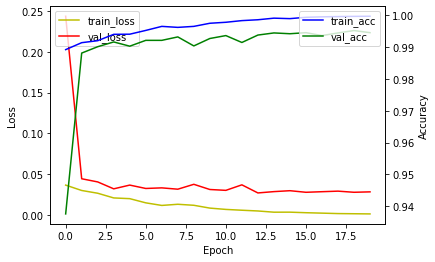

In [15]:
acc_loss_plot(history)